In [147]:
import copy
import json
import os
import re
import shutil
import sys
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import tifffile
import yaml
from einops import rearrange, repeat
from ome_types import from_xml, to_xml
from ome_types.model import OME, Image, Pixels, Channel
from skimage.transform import rescale, resize

In this notebook I'll be covering how to annotate and view a path in a stacked 3D registered dataset.

We'll be starting with the registration performed in the [serial section registration notebook](https://github.com/estorrs/ding-lab-spatial/blob/main/3d_analysis/serial_section_registration.ipynb).

In [14]:
registered_dir = Path('../data/registration_example/registered')

# these are all the registered data files
sorted(registered_dir.rglob('*'))

[PosixPath('../data/registration_example/registered/Z0_HT891Z1-U1_xenium.h5ad'),
 PosixPath('../data/registration_example/registered/Z0_HT891Z1-U1_xenium_morphology.ome.tiff'),
 PosixPath('../data/registration_example/registered/Z0_HT891Z1-U1_xenium_transcripts.parquet'),
 PosixPath('../data/registration_example/registered/Z10_HT891Z1-U4_he.ome.tiff'),
 PosixPath('../data/registration_example/registered/Z5_HT891Z1-U2_he.ome.tiff'),
 PosixPath('../data/registration_example/registered/Z5_HT891Z1-U2_visiumhd.h5ad'),
 PosixPath('../data/registration_example/registered/Z65_HT891Z1-U14_multiplex.ome.tiff')]

Setting an output directory

In [15]:
path_annot_dir = Path('../data/registration_example/path_annotation')
Path(path_annot_dir).mkdir(parents=True, exist_ok=True)

Reading in the data map

In [16]:
data_map = pd.read_csv('HT891Z1_sections.txt', sep='\t')
data_map

,section_id,position,dtype,filepath,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,HT891Z1-U1,0,xenium,/diskmnt/primary/Xenium/data/20240524__182517_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HT891Z1-U2,5,he,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HT891Z1-U2,5,visiumhd,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HT891Z1-U4,10,he,/diskmnt/Users2/estorrs/ding-lab-spatial/data/...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HT891Z1-U14,65,multiplex,/diskmnt/primary/CODEX/HTAN/20240723_Prostate_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Specifying the target section that was used during registration

In [142]:
config = json.load(open(registered_dir / 'config.json'))

target_sid = config['target_sid']
target_mpp = config['target_resolution']
target_size = config['target_size']

## Annotating a region path with QuPath

Here I'll cover how to annotated an interconnected region with QuPath

The first thing we need to do is save a 3D OME-TIF.

This file will consist of the same RGBs we were generating before for each dataset section in the registration notebook, except we will combine them all together into the same image file so it is possible to annotate with image viewing software.

Note that you may want to display different genes than I'm choosing here depending on what your objective is.

First, we'll port over some of the rgb image creation functions

In [66]:
# this is how much we will downscale the OME-TIF we will write
# often it is impractical to write the full resolution OME-TIF for annotation
# here we downscale by 4x
down = 4

In [67]:
def hex_to_rgb(
    hex_str: str # hex color
) -> np.ndarray:
    hex_str = hex_str.lstrip("#")
    x = np.asarray([int(hex_str[i:i+2], 16) for i in (0, 2, 4)]).astype(float)
    x /= 255
    return x

def to_uint8(x):
    """
    Convienence function for converting image to uint8
    """
    x = x.astype(np.float32)
    x /= x.max()
    x *= 255
    x = x.astype(np.uint8)
    return x

def to_pseudocolor(
    data: np.ndarray, # (C, H, W)
    view_settings: dict
) -> np.ndarray:
    """
    Creates an RGB pseudocolor image based on the given image and view settings.
    
    data - (c, h, w)
    view_settings - list of dicts that have the following fields:
        color - hex color for channel
        min_value - min value for channel
        max_value - max value for channel
        gamma - gamma value for channel
    """
    channels = [x['channel'] for x in view_settings]
    rgbs = np.stack([hex_to_rgb(x['color']) for x in view_settings])
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

Here we specify view settings for the CODEX and xenium multiplex images

In [120]:
# view settings for codex multiplex images
multiplex_view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'Vimentin',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

# view settings for xenium multiplex images
xenium_view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': '18S',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'alphaSMA/Vimentin',
        'color': '#ffffff',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

Here we have some helper fuctions to add visium bins and xenium transcript locations for certain genes to an RGB image

In [121]:
def add_pts_to_rgb(rgb, pts, color, size=1):
    """
    rgb - (h w c), uint8
    pts - (n, 2), axis order is x, y
    color - hex color
    size - num pixels to expand point
    """
    rgb_color = hex_to_rgb(color) * 255
    
    x = pts.astype(int)
    xs, ys = x[:, 0], x[:, 1]
    r1s, r2s = ys - size, ys + size
    c1s, c2s = xs - size, xs + size

    r1s[r1s < 0] = 0
    c1s[c1s < 0] = 0

    for r1, r2, c1, c2 in zip(r1s, r2s, c1s, c2s):
        rgb[r1:r2, c1:c2] = rgb_color

    return rgb

def add_xenium_genes_to_rgb(rgb, transcripts, gene_view_settings, size=1):
    """
    Adds transcripts for the given genes to the RGB
    """
    for entry in gene_view_settings:
        gene, color = entry['gene'], entry['color']
        
        pts = transcripts[transcripts['feature_name'] == gene][['x_location', 'y_location']].values / down
        rgb = add_pts_to_rgb(rgb, pts, color, size=size)

    return rgb

def add_visiumhd_genes_to_rgb(rgb, adata, gene_view_settings, size=1):
    """
    Adds bin locations that are positive (more than 1 count) for a given gene to the RGB
    """
    for entry in gene_view_settings:
        gene, color = entry['gene'], entry['color']

        f = adata[:, gene]
        mask = f.X.toarray().flatten() > 0
        pts = f[mask].obsm['spatial'] / down
        rgb = add_pts_to_rgb(rgb, pts, color, size=size)

    return rgb
    

Here we determine which transcripts and what color they will display as

In [122]:
xenium_transcript_view_settings = [
    {
        'gene': 'EPCAM',
        'color': '#00ff00', # green
    },
    {
        'gene': 'KRT5',
        'color': '#ffffff', # white
    }
]

visiumhd_view_settings = [
    {
        'gene': 'KRT5',
        'color': '#ffffff',
    }
]

Grabbing the order and positioning of the sections from the data_map

In [123]:
section_order = []
section_positions = []
for i, row in data_map.sort_values('position').iterrows():
    sid = row['section_id']
    if sid not in section_order:
        section_order.append(sid)
        section_positions.append(row['position'])

section_order, section_positions

(['HT891Z1-U1', 'HT891Z1-U2', 'HT891Z1-U4', 'HT891Z1-U14'], [0, 5, 10, 65])

Creating RGBs for each section

In [124]:
rgbs = []

for section_id, position in zip(section_order, section_positions):
    section_dtypes = set(data_map[data_map['section_id'] == section_id]['dtype'])

    # if we are a visiumhd section
    if 'visiumhd' in section_dtypes:
        path = registered_dir / f'Z{position}_{section_id}_visiumhd.h5ad'
        adata = sc.read_h5ad(path)
        genes = list({c['gene'] for c in visiumhd_view_settings})
        adata = adata[:, genes]

        path = registered_dir / f'Z{position}_{section_id}_he.ome.tiff'
        x = tifffile.imread(path)
        rgb = rearrange(x, 'c h w -> h w c')
        rgb = rgb[::down, ::down]
        
        rgb = add_visiumhd_genes_to_rgb(rgb, adata, visiumhd_view_settings, size=1)

    # if we are a xenium section
    elif 'xenium' in section_dtypes:
        # read transcripts
        path = registered_dir / f'Z{position}_{section_id}_xenium_transcripts.parquet'
        transcripts = pd.read_parquet(path)
        genes = {c['gene'] for c in xenium_transcript_view_settings}
        # filter for only relavent genes
        transcripts = transcripts[[g in genes for g in transcripts['feature_name']]]

        # read multiplex image
        path = registered_dir / f'Z{position}_{section_id}_xenium_morphology.ome.tiff'
        tf = tifffile.TiffFile(path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]
        keep_channels = [c['channel'] for c in xenium_view_settings]
        channel_indices = [i for i, x in enumerate(channel_order) if x in keep_channels]
        x = np.stack([tf.pages[i].asarray()[::down, ::down] for i in channel_indices])

        # create pseudocolor rgb
        rgb = to_pseudocolor(x, xenium_view_settings)
        rgb = add_xenium_genes_to_rgb(rgb, transcripts, xenium_transcript_view_settings, size=1)

    # if we are a multiplex section
    elif 'multiplex' in section_dtypes:
        # read multiplex image
        path = registered_dir / f'Z{position}_{section_id}_multiplex.ome.tiff'
        tf = tifffile.TiffFile(path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]
        keep_channels = [c['channel'] for c in multiplex_view_settings]
        channel_indices = [i for i, x in enumerate(channel_order) if x in keep_channels]
        x = np.stack([tf.pages[i].asarray()[::down, ::down] for i in channel_indices])

        # create pseudocolor rgb
        rgb = to_pseudocolor(x, multiplex_view_settings)

    # if we are an H&E
    elif 'he' in section_dtypes:
        path = registered_dir / f'Z{position}_{section_id}_he.ome.tiff'
        x = tifffile.imread(path)
        rgb = rearrange(x, 'c h w -> h w c')
        rgb = rgb[::down, ::down]

    rgbs.append(rgb)

Sometimes the sizes between sections are a few pixels off because of the upsampling and downsampling. Here we pick the most common size and rescale everything to that

In [125]:
shapes = [rgb.shape for rgb in rgbs]
target_shape = Counter(shapes).most_common()[0][0][:2]

target_shape

(7685, 8543)

In [126]:
for i, rgb in enumerate(rgbs):
    if rgb.shape[:2] != target_shape:
        rgb = resize(rgb, target_shape, preserve_range=True, anti_aliasing=False)
        rgb = rgb.astype(np.uint8)

    rgbs[i] = rgb

stacked_rgbs = np.stack(rgbs)
stacked_rgbs.shape

(4, 7685, 8543, 3)

Displaying the stacked RGBs

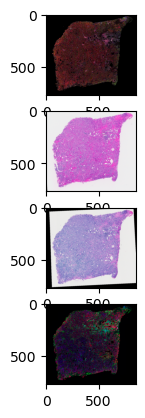

In [133]:
fig, axs = plt.subplots(nrows=len(rgbs))

for rgb, ax in zip(stacked_rgbs, axs):
    ax.imshow(rgb[::10, ::10])

Zooming in

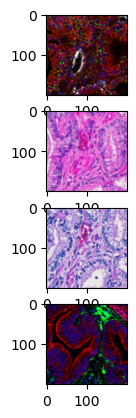

In [134]:
# taking a look at a specific tile
r1, r2, c1, c2 = 4000, 4200, 4000, 4200
fig, axs = plt.subplots(nrows=len(rgbs))

for rgb, ax in zip(stacked_rgbs, axs):
    ax.imshow(rgb[r1:r2, c1:c2])


Writing the output file that we will load into QuPath to do region annotation

In [138]:
output_fp = path_annot_dir / 'stacked_rgb.ome.tiff'

ome_model = OME(
    images=[
        Image(
            pixels=Pixels(
                dimension_order='XYCZT',
                type='uint8',
                physical_size_x_unit='µm',
                physical_size_y_unit='µm',
                physical_size_x=target_mpp * down,
                physical_size_y=target_mpp * down,
                size_c=stacked_rgbs.shape[3],
                size_t=1,
                size_x=stacked_rgbs.shape[2],
                size_y=stacked_rgbs.shape[1],
                size_z=stacked_rgbs.shape[0],
                
                channels=[
                    Channel(name=name) for name in ['r', 'g', 'b']
                ]
            )
        )
    ]
)

with tifffile.TiffWriter(output_fp, ome=True, bigtiff=True) as out_tif:
    out_tif.write(
        rearrange(stacked_rgbs, 'z y x c -> 1 z c y x'),
        compression = 'LZW'
    )
    xml_str = to_xml(ome_model)
    out_tif.overwrite_description(xml_str.encode())

In [139]:
output_fp

PosixPath('../data/registration_example/path_annotation/stacked_rgb.ome.tiff')

## Annotating a 3D path

See [this video](https://wustl.box.com/s/ml358qgb16mbykh6e0xqko0ehrw5e4ls) for instructions on how to annotate a path.

We do annotation with QuPath. When annotating keep in mind that you can scroll through the different z sections with the little scroll thing in the top left.

Also, sometimes it is possible to create "invalid" polygons when annotating. To determine whether a polygon is valid or not, click on the annotation in the annotation tab, and where it says parameter it should have an actual value, not NaN.

When exporting the annotations as a geojson at the end, make sure to select all annotations, not selected annotations (unless that is what you want).

## Loading annotated regions

We load the annotations be loading the exported geojson file from the previous step.

In [262]:
def load_regions(regions_fp, border=10):
    regions = json.load(open(regions_fp))['features']
    for x in regions:
        try:
            np.asarray(x['geometry']['coordinates'])
        except ValueError:
            rid = x['id']
            raise RuntimeError(f'{rid} failed to import. Make sure it is a valid polygon.')
            
    regions = [{
        'id': x['id'],
        'z': x['geometry']['plane']['z'] if 'plane' in x['geometry'] else 0,
        'coordinates': np.asarray(x['geometry']['coordinates']),
    } for x in regions]
    regions = [x for x in regions if len(x['coordinates'].shape) == 3]
    for x in regions:
        x['coordinates'] = x['coordinates'][0][:, [1, 0]]
        x['mask'] = skimage.draw.polygon2mask(np.asarray(target_size) // down, x['coordinates'])
        x['position'] = section_positions[x['z']]
        x['section_id'] = section_order[x['z']]

    return regions

Reading in the regions

In [263]:
regions = load_regions(path_annot_dir / 'stacked_rgb.geojson')
len(regions)

4

In [264]:
region = regions[0] # grabbing the first region
region.keys()

dict_keys(['id', 'z', 'coordinates', 'mask', 'position', 'section_id'])

You can see we have a variety of different information attached to each region

- id - region identifier
- z - z index of section that region is on
- seciont_id - section id that region is on
- position - z-depth in microns of the region
- coordinates - coordinates of the annotated polygon
- mask - a binary mask, where 1s represent pixels that are a part of the region, and 0s are background

Below I'm displaying some of the region info

In [265]:
region['id'], region['section_id'], region['z'], region['position']

('94698567-6d05-4a5e-9592-6893b9ec9e4e', 'HT891Z1-U1', 0, 0)

In [266]:
region['coordinates'].shape, region['coordinates'][:5]

((46, 2),
 array([[2996, 1299],
        [3007, 1251],
        [3057, 1183],
        [3057, 1182],
        [3058, 1182]]))

For display purposes we define a bounding box around the annotated area

In [267]:
expansion_dist = 100
r1, c1 = region['coordinates'].min(0) - expansion_dist
r2, c2 = region['coordinates'].max(0) + expansion_dist
r1, r2, c1, c2

(np.int64(2896), np.int64(3620), np.int64(1023), np.int64(1703))

In [268]:
region['mask'].shape

(7685, 8542)

Showing the mask of the annotated region

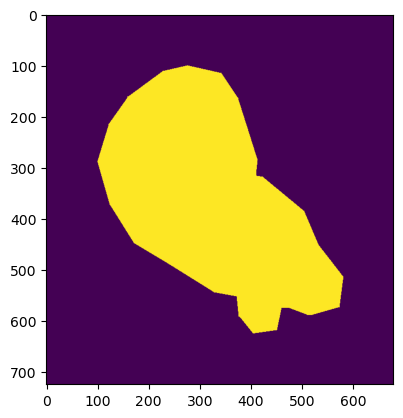

In [269]:
plt.imshow(region['mask'][r1:r2, c1:c2])

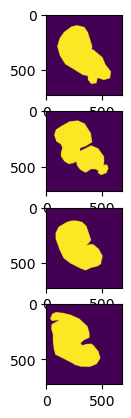

In [270]:
fig, axs = plt.subplots(nrows=len(regions))
for region, ax in zip(regions, axs):
    mask = region['mask'][r1:r2, c1:c2]
    ax.imshow(mask)

We can also display the masked region on top of the original stacked RGBs

In [278]:
def get_border_ring(mask, border=10):
    ring = mask.copy()
    ring = skimage.segmentation.expand_labels(ring, distance = border)
    ring = ring ^ mask
    return ring

def add_ring_to_rgb(rgb, mask, border=10, hex_color='#ffff00'):
    color = hex_to_rgb(hex_color) * 255
    ring = get_border_ring(mask, border=border)
    rgb[ring] = color
    return rgb
    

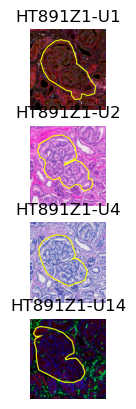

In [279]:
fig, axs = plt.subplots(nrows=len(regions))

for region, ax in zip(regions, axs):
    rgb = stacked_rgbs[region['z']].copy()
    mask = region['mask'].copy()

    rgb = rgb[r1:r2, c1:c2]
    mask = mask[r1:r2, c1:c2]

    rgb = add_ring_to_rgb(rgb, mask)

    ax.imshow(rgb)
    ax.set_title(region['section_id'])
    ax.axis('off')


## Getting expression for a region

For various analyses it is often useful to get the expression data from within an annotated region. Below I give examples of how to accomplish this for the various data types.
    

#### Multiplex